# Perceiver

According to "Perceiver: General Perception with Iterative Attention", [arXiv:2103.03206 [cs.CV]](https://arxiv.org/abs/2103.03206)

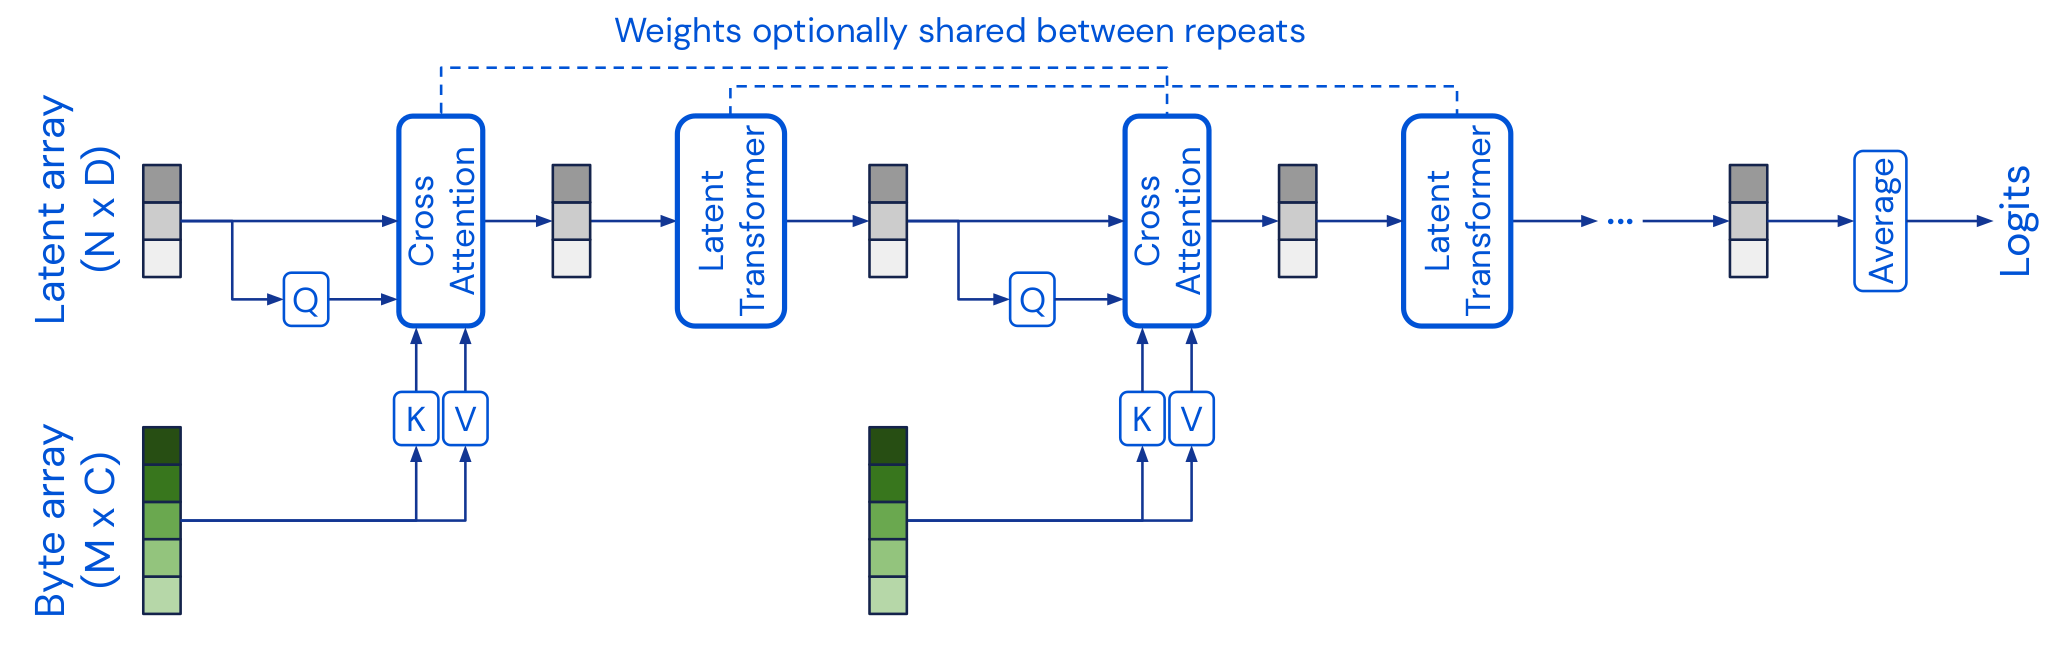

"With great flexibility comes great overfitting" 😎

## Configuration

Imports

In [1]:
import math
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

IMAGE_SIZE = 32
NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [5]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

In [7]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

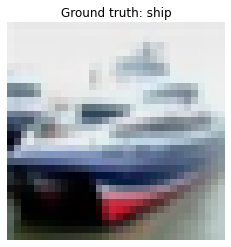

In [8]:
dataset_show_image(test_dset, 1)

## Model

Attention

In [9]:
class Attention(nn.Module):
    def __init__(self, dims, head_dim, heads, p_drop=0.):
        super().__init__()
        query_dim = dims[0]
        context_dim = query_dim if len(dims) == 1 else dims[1]
        inner_dim = head_dim * heads
        
        self.head_shape = (heads, head_dim)
        self.scale = head_dim**-0.5

        self.to_keys = nn.Linear(context_dim, inner_dim)
        self.to_values = nn.Linear(context_dim, inner_dim)
        self.to_queries = nn.Linear(query_dim, inner_dim)
        self.unifyheads = nn.Linear(inner_dim, query_dim)

        self.drop = nn.Dropout(p_drop)

    def forward(self, x, context=None):
        if context is None: context = x
        
        k_shape = context.shape[:-1] + self.head_shape
        q_shape = x.shape[:-1] + self.head_shape
        
        keys = self.to_keys(context).view(k_shape).transpose(-3, -2) # move head forward to the batch dim
        values = self.to_values(context).view(k_shape).transpose(-3, -2)
        queries = self.to_queries(x).view(q_shape).transpose(-3, -2)

        att = queries @ keys.transpose(-2, -1)
        att = F.softmax(att * self.scale, dim=-1)
        
        out = att @ values
        out = out.transpose(1, 2).contiguous().flatten(2) # move head back
        out = self.unifyheads(out)
        out = self.drop(out)
        return out

Utilities

In [10]:
class Sequential(nn.Sequential):
    def forward(self, *xs):
        for module in self:
            xs = module(*xs) if type(xs) == tuple else module(xs)
        return xs

Weight before residual according to

"ReZero is All You Need: Fast Convergence at Large Depth", [arXiv:2003.04887 [cs.LG]](https://arxiv.org/abs/2003.04887)

In [11]:
class Residual(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.residual = Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, *xs):
        return xs[0] + self.gamma * self.residual(*xs)

In [12]:
class NormAll(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.norms = nn.ModuleList([nn.LayerNorm(dim) for dim in dims])
    
    def forward(self, *xs):
        xs = tuple(norm(x) for x, norm in zip(xs, self.norms))
        if len(xs) == 1: xs = xs[0]
        return xs

Attention Block

In [13]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, mult=4, p_drop=0.):
        hidden_dim = dim * mult
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p_drop)
        )

In [14]:
class Block(Sequential):
    def __init__(self, dims, head_dim, heads, p_drop=0.):
        dim = dims[0]
        super().__init__(
            Residual(NormAll(dims), Attention(dims, head_dim, heads, p_drop=p_drop)),
            Residual(nn.LayerNorm(dim), FeedForward(dim, p_drop=p_drop))
        )

Position Encoding

In [15]:
def fourier_encode_1d(size, bands, base=2):
    axis = torch.linspace(-1., 1., steps=size).unsqueeze(1)
    scales = torch.logspace(0., math.log(size/2)/math.log(base), steps=bands, base=base)
    args =  axis * scales * math.pi
    enc = torch.cat([axis, args.sin(), args.cos()], dim=1)
    return enc

In [16]:
def fourier_encode(shape, bands, base=2):
    enc_list = []
    for num, size in enumerate(shape):
        reps = [1] * len(shape)
        reps[num] = size
        enc = fourier_encode_1d(size, bands, base)
        enc_expanded = enc.view(*reps, -1).expand(*shape, -1)
        enc_list.append(enc_expanded)
    enc = torch.cat(enc_list, dim=-1)
    enc = enc.flatten(0, -2)
    return enc

In [17]:
class PositionEncoding(nn.Module):
    def __init__(self, shape, bands):
        super().__init__()
        #self.position_coding = nn.Parameter(torch.zeros(np.prod(shape), bands))
        
        position_coding = fourier_encode(shape, bands)
        self.register_buffer('position_coding', position_coding)
    
    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)
        pos = self.position_coding.expand(x.size(0), -1, -1)
        out = torch.cat([x, pos], dim=-1)
        return out

Head

In [18]:
class GlobalAvgPool(nn.Module):
    def forward(self, x):
        return x.mean(dim=-2)

In [19]:
class Head(nn.Sequential):
    def __init__(self, dim, classes, p_drop=0.):
        super().__init__(
            nn.LayerNorm(dim),
            GlobalAvgPool(),
            nn.Dropout(p_drop),
            nn.Linear(dim, classes)
        )

Perceiver

In [20]:
class Transformer(nn.Sequential):
    def __init__(self, dim, head_dim, heads, depth, p_drop):
        layers = [Block([dim], head_dim, heads, p_drop=p_drop) for _ in range(depth)]
        super().__init__(*layers)

In [21]:
class Perceiver(nn.Module):
    def __init__(self, classes, latent_size, latent_dim, head_dim, freq_bands,
                 transformer_depth, heads, num_iterations, in_channels=3, p_drop=0.):
        super().__init__()
        pos_enc_dim = 2 * (2 * freq_bands + 1)
        self.to_embedding = PositionEncoding((IMAGE_SIZE, IMAGE_SIZE), freq_bands)
        self.cross_attn = Block([latent_dim, pos_enc_dim + in_channels], latent_dim, 1, p_drop)
        self.latent_transformer = Transformer(latent_dim, head_dim, heads, transformer_depth, p_drop)
        self.head = Head(latent_dim, classes, p_drop)
        
        self.latent = nn.Parameter(torch.randn(latent_size, latent_dim))
        self.num_iterations = num_iterations
    
    def forward(self, data):
        data = self.to_embedding(data)
        x = self.latent
        for num in range(self.num_iterations):
            x = self.cross_attn(x, data)
            x = self.latent_transformer(x)
        out = self.head(x)
        return out

In [22]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [23]:
model = Perceiver(NUM_CLASSES, latent_size=64, latent_dim=256, head_dim=64, freq_bands=10,
                  transformer_depth=6, heads=8, num_iterations=6, p_drop=0.1)

In [24]:
model.apply(init_linear);

In [25]:
model.to(DEVICE);

In [26]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 7,017,330


## Training

### History

In [27]:
class History:
    def __init__(self):
        self.values = defaultdict(list)

    def append(self, key, value):
        self.values[key].append(value)

    def reset(self):
        for k in self.values.keys():
            self.values[k] = []

    def _begin_plot(self):
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)

    def _end_plot(self, ylabel):
        self.ax.set_xlabel('epoch')
        self.ax.set_ylabel(ylabel)
        plt.show()

    def _plot(self, key, line_type='-', label=None):
        if label is None: label=key
        xs = np.arange(1, len(self.values[key])+1)
        self.ax.plot(xs, self.values[key], line_type, label=label)

    def plot(self, key):
        self._begin_plot()
        self._plot(key, '-')
        self._end_plot(key)

    def plot_train_val(self, key):
        self._begin_plot()
        self._plot('train ' + key, '.-', 'train')
        self._plot('val ' + key, '.-', 'val')
        self.ax.legend()
        self._end_plot(key)

### Optimizer

In [28]:
def separate_parameters(model):
    # biases, and layernorm/embedding weights will not be decayed for regularization
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear,)
    modules_no_weight_decay = (nn.LayerNorm, PositionEncoding)

    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, Residual) and param_name.endswith("gamma"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, Perceiver) and param_name.endswith("latent"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [29]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = separate_parameters(model)
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

### Setup trainer

In [30]:
loss = nn.CrossEntropyLoss()

In [31]:
optimizer = get_optimizer(model, learning_rate=1e-6, weight_decay=1e-2)

In [32]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [33]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [34]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [35]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [36]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [37]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [38]:
history = History()

In [39]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history.append('train loss', train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history.append('val loss', val_loss)
    history.append('val acc', val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [40]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/20 - train: loss 2.303; val: loss 2.299 accuracy 0.115
2/20 - train: loss 2.174; val: loss 2.153 accuracy 0.176
3/20 - train: loss 2.068; val: loss 2.026 accuracy 0.245
4/20 - train: loss 1.980; val: loss 1.907 accuracy 0.304
5/20 - train: loss 1.882; val: loss 1.891 accuracy 0.318
6/20 - train: loss 1.796; val: loss 1.728 accuracy 0.368
7/20 - train: loss 1.740; val: loss 1.614 accuracy 0.421
8/20 - train: loss 1.665; val: loss 1.568 accuracy 0.438
9/20 - train: loss 1.609; val: loss 1.528 accuracy 0.452
10/20 - train: loss 1.582; val: loss 1.485 accuracy 0.476
11/20 - train: loss 1.525; val: loss 1.450 accuracy 0.476
12/20 - train: loss 1.501; val: loss 1.387 accuracy 0.498
13/20 - train: loss 1.491; val: loss 1.370 accuracy 0.504
14/20 - train: loss 1.429; val: loss 1.324 accuracy 0.528
15/20 - train: loss 1.425; val: loss 1.333 accuracy 0.527
16/20 - train: loss 1.372; val: loss 1.303 accuracy 0.536
17/20 - train: loss 1.376; val: loss 1.299 accuracy 0.537
18/20 - train: loss 1.3

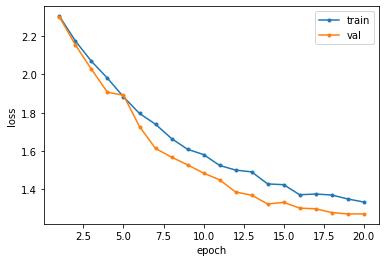

In [41]:
history.plot_train_val('loss')

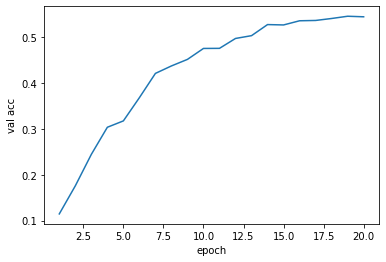

In [42]:
history.plot('val acc')